# Для каких задач подходит k_means? 
1. k_means хорошо справляется с кластеризацией равномерно распределенных данных
2. k_means, на мой взгляд, сильно зависит от случайности, а именно от того, как лягут начальные центроиды(даже если случайно выбирается только одна). Хотя, полагаю, что можно и от зависимости от рандома избавиться, если выбирать первую центроиду по какой-нибудь характеристике, например плотности.
3. Из второго следует, что с **первого раза** постоянно получать идеальную кластеризацию для произвольного датасета невозможно, придется, ориентируясь на различные метрики(например на матрицу попарных расстояний), подгонять.
4. k_means подходит для двумерных задач с шариками. Кроме того, что k_means может их кластеризовать правильно с первого раза, так даже если и не с первого, легко будет подогнать, так как мы визуально видим кластеризацию.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import sklearn as sk

In [320]:

def visualize(x, y, cl):
#     X = np.concatenate((x, cl))
#     Y = np.concatenate((y, np.ones(cl.shape[0]) * CENTER_COLOR))
    plt.scatter(x[:,0], x[:,1], c=y)
    plt.scatter(cl[:,0], cl[:,1], c="red", marker="s", edgecolor="black")
    

def get_closest(point, c, k):
    diff = np.ones((k, 2)) * point - c
    dist = np.linalg.norm(diff, axis = 1)
    nearest = np.argmin(dist)
    return nearest

def calc_clusters(points, centers, k):
    return np.array([get_closest(x, centers, k) for x in points])

def points_from_cluster(points, groups, i):
    return points[groups == i]

def update(points, groups, centers, k):
    new_centers = []
    for i in range(k):
        cluster = points_from_cluster(points, groups, i)
        if cluster.size == 0: # деление на 0 (бывает, когда 2 центра совпадают)
            new_centers.append(centers[i])
            continue
        new_centers.append(cluster.mean(axis=0))
    new_centers = np.array(new_centers)
    new_groups = calc_clusters(points, new_centers, k)
    return new_centers, new_groups

def get_far(points, centers): # убрать из points точки, которые уже в centers ? Хотя, вроде в этом нет необходимости
    mean_dists = np.array([np.mean(np.linalg.norm(np.ones((centers.shape[0],2))*point-centers, ord=2, axis=1)) for point in points])
    return np.argmax(mean_dists)

def get_uniform_far(points, centers):
    dists_corelation = np.array([np.cov(np.linalg.norm(np.ones((centers.shape[0],2))*point-centers, ord=2, axis=1)) for point in points])
    return np.argmin(dists_corelation)

def init_centers(points, k, init_h=0, show_steps=0, mod_start=3):
    if init_h == 'max_dist' or init_h == 'max_dist_mod':
        centers = points[np.random.choice(points.shape[0], size=1), :]
        for i in range(1, k):
            if show_steps:
                visualize(points, np.zeros(points.shape[0]), centers) 
                plt.show()
            if init_h == 'max_dist_mod' and i >= mod_start - 1:
                new_center = points[get_uniform_far(points, centers)]
            else:
                new_center = points[get_far(points, centers)]
            centers = np.append(centers, new_center.reshape((1,2)), axis=0)
    elif init_h == 'k_means++':
        centers = points[np.random.choice(points.shape[0], size=1), :]
        for i in range(1, k): 
            if show_steps:
                visualize(points, np.zeros(points.shape[0]), centers) 
                plt.show()
            min_dists = [np.sqrt(np.min(np.linalg.norm(np.ones((centers.shape[0], 2)) * point - centers, ord=2, axis=1))) for point in points]
            probs = min_dists / np.sum(min_dists)
            new_center = points[np.random.choice(points.shape[0], size=1, p = probs)]
            centers = np.append(centers, new_center.reshape((1,2)), axis=0)
    else:
        centers = points[np.random.choice(points.shape[0], size=k, replace=False), :]
    return centers

def k_means(points, k, init_h=0, just_init = 0, show_steps = 0, show_result = 0, show_matrix = 0, mod_start=3):
    """
    
    points - датасет
    k - количество кластеров
    
    init_h - начальная инициализация, варианты: 
        0 - случайный выбор,
        'max_dist' - макс. расстояние, 
        'max_dist_mod' - модификация max_dist, ориентированность на равноудаленность от центроид,
        'k_means++'
    mod_start - с какой начальной центроиды начинать ориентироваться на равноудаленность при max_dist_mod
    
    show_steps - показать шаги построения кластеризации (включая шаги выбора нач. центроид)
    show_result - показать окончательный результат
    just_init - произвести только инициализацию начальных центроид
    
    """
    points = np.array(points)
    centers = init_centers(points, k, init_h, show_steps, mod_start) 
    groups = calc_clusters(points, centers, k) # точка <-> номер кластера (от 0 до k)
    
    if show_steps:
        visualize(points, groups, centers) 
        plt.show()
    
    if just_init == 0:
        while (1):
            old_centers = centers
            centers, groups = update(points, groups, centers, k)
            if show_steps:
                visualize(points, groups, centers) 
                plt.show()
            if np.all(old_centers == centers):
                break
    if show_result and not show_steps:
        visualize(points, groups, centers)
    
    if show_matrix:
        sorted_points = sort_by_clusters(points, groups)
        distance_matrix = get_distance_matrix(sorted_points)
        visualize_matrix(distance_matrix)
    return centers, groups

# Матрица попарных расстояний

In [292]:
def get_distance_matrix(points):
    matrix1 = np.tile(points,(points.shape[0], 1)).reshape(points.shape[0],points.shape[0],2)
    matrix2 = np.tile(points,(1, points.shape[0])).reshape(points.shape[0],points.shape[0],2)
    distance_matrix = np.linalg.norm(matrix1 - matrix2, axis=2)

    distance_matrix = distance_matrix / np.max(distance_matrix)

    return distance_matrix

def sort_by_clusters(points, clusters):
    return points[np.argsort(clusters)]

def visualize_matrix(matrix):
    plt.matshow(matrix)
    plt.colorbar()

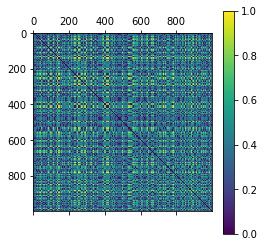

In [322]:
from sklearn.datasets import make_blobs
k = 10
X, y = make_blobs(centers=k, cluster_std=0.6, random_state=2, n_samples = 1000)

distance_matrix = get_distance_matrix(X)
visualize_matrix(distance_matrix)

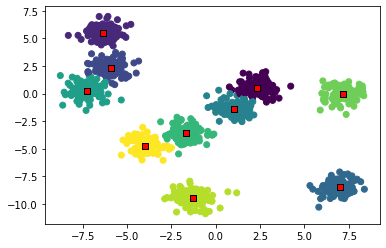

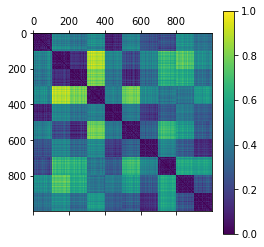

In [326]:
centers, groups = k_means(X, k, init_h='k_means++', mod_start=4, show_steps=0, show_result=1, show_matrix=1, just_init=0)

# Наблюдения по начальной инициализации
0. Случайная иницилизация довольно-таки плохо справляется с "шариками", например это видно в *интересном тесте 1*(который находится в самом конце блокнота)
1. Заметил, что при эвристике `max_dist`, в отличие от случайной инициализации, площади кластеров становятся равны(+-) на равномерно распределенном датасете.
2. `max_dist` часто неправильно кластеризует, особенно это видно на *интересном тесте 1*. Связано это с тем, что при выборе больше, чем 4х центров, 5ые и далее центры начинают выбираться в нелогичных с точки зрения кластеризации местах(это видно на дефолтном тесте равн. распределения, в данном примере 5ые и далее совпадают с уже выбранными центрами). Необходима модификация.
3. Модификация: начиная с `mod_start`-го центра выбирать не самую удаленную, а РАВНОУДАЛЕННУЮ точку.
4. Реализовал `max_dist_mod`(3 пункт), используя в качестве характеристика равноудаленности - ковариацию расстояний до центров. Действительно, при правильном выборе `mod_start`, можно получить хорошие результаты. В случае *интересного теста 1* (5 шариков) необходимо выбрать `mod_start` = 4 (т. е. начиная с 4го центра, выбор будет идти по хар-ке равноудаленности от остальных центров). Вообще, кажется идеальным для двумерного случая брать `mod_start` = 4, для n-мерного = 2^n.

# Различные результаты кластеризации при различных начальных инициализациях

**DEFAULT RANDOM INTEGER TEST** <br />
Равномерное распределение

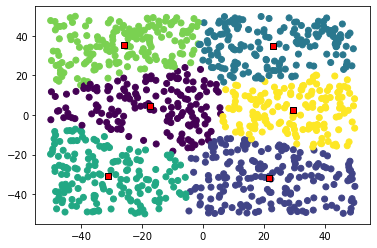

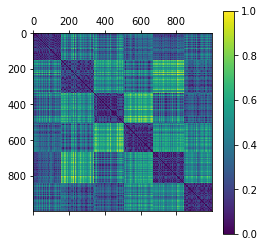

In [328]:
np.random.seed(1)
n = 1000
X = (np.random.random((n, 2)) - 0.5)*100
k = 6
mod_start = 4

centers, groups = k_means(X, k, init_h='max_dist_mod', mod_start=mod_start, show_steps=0, show_result=1, show_matrix=1, just_init=0)

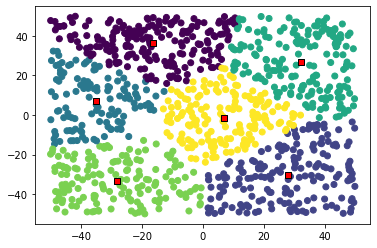

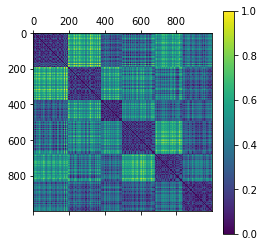

In [329]:
centers, groups = k_means(X, k, init_h="k_means++", show_steps=0, show_result=1, show_matrix=1, just_init=0)

**BLOBS TEST** <br />
Шарики

In [330]:
from sklearn.datasets import make_blobs
k = 8
X, y = make_blobs(centers=k, cluster_std=0.6, random_state=2, n_samples = 1000)

**Эталон**


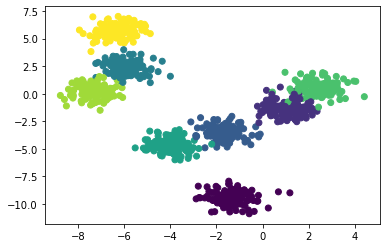

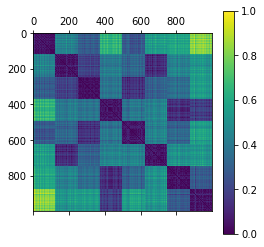

In [332]:
plt.scatter(X[:,0], X[:,1], c=y)
visualize_matrix(get_distance_matrix(sort_by_clusters(X, y)))

**MAX_DIST_MOD** <br />
`mod_start = 4`

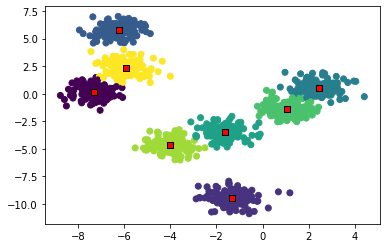

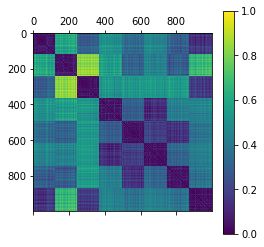

In [333]:
mod_start = 4
centers, groups = k_means(X, k, init_h='max_dist_mod', mod_start=mod_start, just_init=0, show_steps=0, show_matrix=1, show_result=1)

**MAX_DIST**

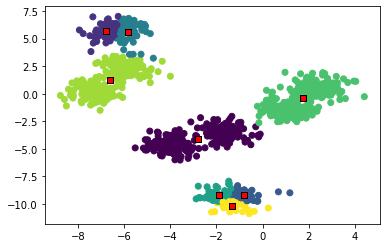

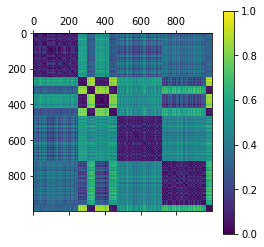

In [336]:
centers, groups = k_means(X, k, init_h='max_dist', just_init=0, show_steps=0,show_matrix=1, show_result=1)

**Случайная инициализация начальных кластеров**

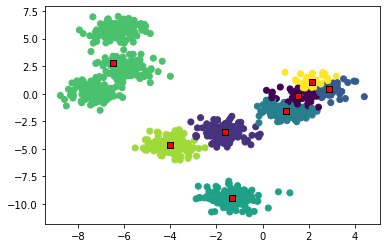

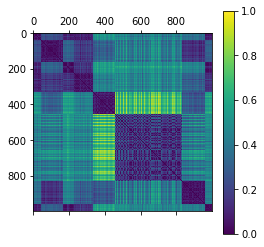

In [337]:
centers, groups = k_means(X, k, init_h=0, just_init=0, show_steps=0,show_matrix=1, show_result=1)

**K_MEANS++**

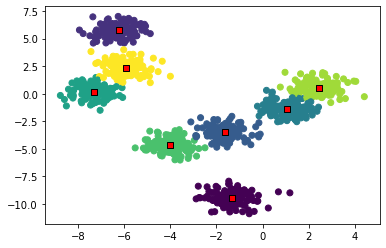

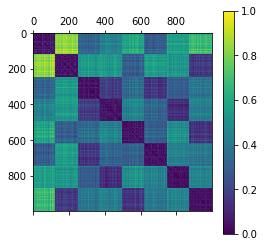

In [348]:
centers, groups = k_means(X, k, init_h='k_means++', just_init=0, show_steps=0,show_matrix=1, show_result=1)

# Скорость
N = кол-во элементов в выборке <br />
k = кол-во кластеров
1. **k = 2**
    1. Как видно из графиков, при **N <= 10000**, все алгоритмы отрабатывают по времени +- одинаково, кроме k_means++, график которой в некоторых случаях находится чуть ниже остальных.
    2. При **N <= 100000** ситуация аналогичная, k_means++ опережает остальные алгоритмы на ~7 единиц времени(секунд, полагаю).
2. **k = 6**
    1. При **N <= 10000**, k_means++ почти в 2 раза опережает по времени остальные алгоритмы.
    2. при **N <= 100000**, k_means++ тоже лидирует, но разница не особо большая
3. **k = 100**
    1. При **N <= 10000**, все алгоритмы показывают себя +- одинаково по времени
    2. При **N <= 100000**, k_means++ опережает остальные алгоритмы чуть ли не в 2 раза.
    
**Вывод**: <br />
В целом зависимость от N - **линейная**. <br />
Можно отметить, что k_means++ в большинстве случаев окажется быстрее остальных алгоритмов. <br />
А при условии что **k >> 1** и **N >> 1** так и вовсе опережает остальные алгоритмы в 2 раза, как показал тест 3B. 

In [113]:
from time import time

In [135]:
np.random.seed(1)
def make_tests(k, start_exp = 1, end_exp=3):
    k = 2
    tests = np.array([pow(10, x) for x in range(start_exp, end_exp + 1)])
    etime = np.zeros((tests.size, 4))
    for n in range(tests.size):
        X = (np.random.random((tests[n], 2)) - 0.5)*100

        stime = time()
        k_means(X, k, init_h=0, just_init=0, show_steps=0, show_result=0)
        etime[n][0] = time() - stime

        stime = time()
        k_means(X, k, init_h='max_dist', just_init=0, show_steps=0, show_result=0)
        etime[n][1] = time() - stime

        stime = time()
        k_means(X, k, init_h='max_dist_mod', mod_start=4, just_init=0, show_steps=0, show_result=0)
        etime[n][2] = time() - stime

        stime = time()
        k_means(X, k, init_h='k_means++', just_init=0, show_steps=0, show_result=0)
        etime[n][3] = time() - stime

    plt.plot(tests, etime[:,0], c='red', label='random')
    plt.plot(tests, etime[:,1], label='max_dist')
    plt.plot(tests, etime[:,2], label='max_dist_mod(4)')
    plt.plot(tests, etime[:,3], label='k_means++')
    plt.grid()
    plt.xlabel('$x$')
    plt.ylabel('time')
    plt.legend()

# K = 2

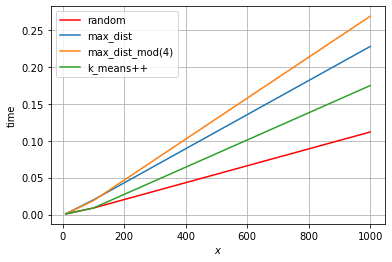

In [136]:
make_tests(k=2, start_exp=1, end_exp=3)

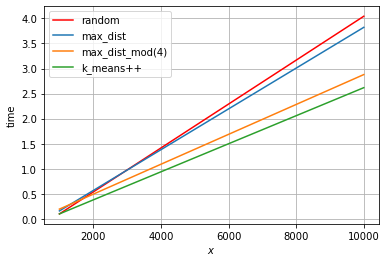

In [139]:
make_tests(k=2, start_exp=3, end_exp=4)

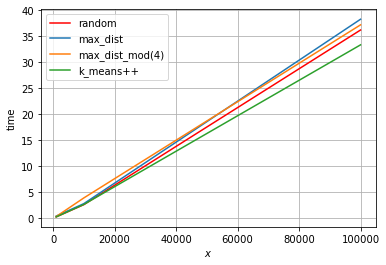

In [137]:
make_tests(k=2, start_exp=3, end_exp=5)

# K = 6

In [144]:
k = 6

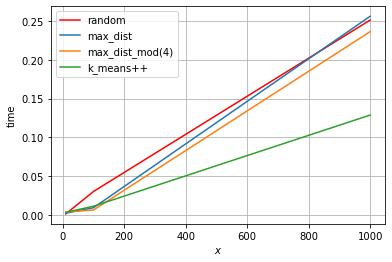

In [145]:
make_tests(k, start_exp=1, end_exp=3)

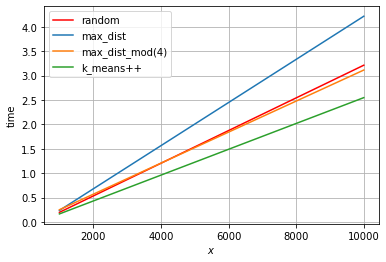

In [146]:
make_tests(k, start_exp=3, end_exp=4)

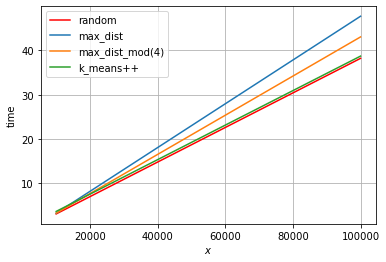

In [147]:
make_tests(k, start_exp=4, end_exp=5)

# K = 100

In [149]:
k = 100

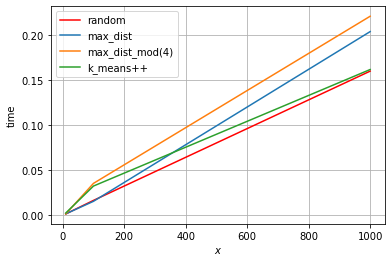

In [150]:
make_tests(k, start_exp=1, end_exp=3)

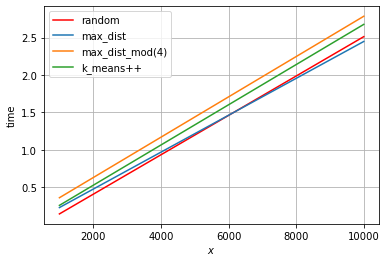

In [151]:
make_tests(k, start_exp=3, end_exp=4)

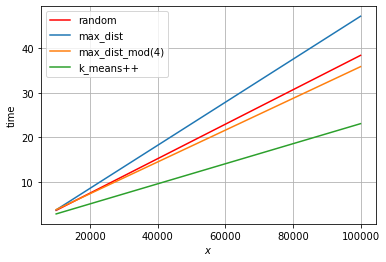

In [152]:
make_tests(k, start_exp=4, end_exp=5)

# Выбор числа кластеров
1. Выбирать число кластеров можно просто применяя алгоритм k_means начиная с 2х до N кластеров.
2. Получив результаты по каждому i от 2 до N, выбрать то i, у которого наилучшая матрица попарных расстояний(либо наибольший score) 

# Интересный тест 1

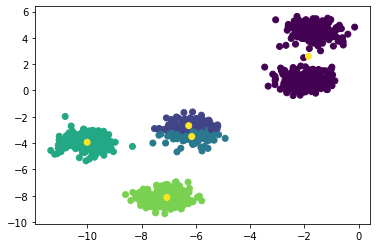

In [154]:
from sklearn.datasets import make_blobs
k = 5
X, y = make_blobs(centers=k, cluster_std=0.5, random_state=1, n_samples = 1000)

centers, groups = k_means(X, k)
visualize(X, groups, centers)
